## 4\. Model Building

Now that we have the data ready, its time to start making predictive models. I will go through 5 scikit-learn simple models including linear regression, decision tree and random forest.

Since I’ll be making many models, instead of repeating the codes again and again, I would like to define a generic function which takes the algorithm and data as input and makes the model, performs cross-validation and generates submission.

I'll do the same thing later with H2O and XGboost

In [1]:
import pandas as pd
import numpy as np
import time
import csv
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import math

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [2]:
#   rmsle - error function used in LB
def rmsle_func(actual, predicted):
    return np.sqrt(msle(actual, predicted))
def msle(actual, predicted):
    return np.mean(sle(actual, predicted))
def sle(actual, predicted):
    return (np.power(np.log(np.array(actual)+1) -  np.log(np.maximum(0,np.array(predicted))+1), 2))

def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(max(0,y_pred[i]) + 1) - math.log(max(0,y[i]) + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

#Define target and ID columns:
target = 'Demanda_uni_equil'
IDcol = 'id'
from sklearn import cross_validation, metrics

def modelfit(alg, dtrain, dval, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    y = alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #Predict validation (holdout) set:
    dval_predictions = alg.predict(dval[predictors])

    #Perform cross-validation:
    #cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=2, scoring='mean_squared_error')
    #cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    #print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    #print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
      
    print ('RMSLE TRAIN: ', rmsle_func(dtrain[target].values, dtrain_predictions))
    print ('RMSLE VAL: ', rmsle_func(dval[target].values, dval_predictions))
    #print ('rmsle: ', rmsle(dtrain[target].values, dtrain_predictions))
    print ('RMSE TRAIN', np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ('RMSE VAL', np.sqrt(metrics.mean_squared_error(dval[target].values, dval_predictions)))
        
      
        
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    
    #Export submission file:
    #IDcol.append(target)
    #submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission = dtest[[IDcol,target]].copy()
    submission[IDcol] = submission[IDcol].astype(int)
    submission.to_csv("./Submissions/"+filename, index=False)
    

In [3]:
#now we load our modified train and test set

tic()
#train = pd.read_csv('./input-data/train_modified.csv', nrows = 500000)
#test = pd.read_csv('./input-data/test_modified.csv', nrows = 500000)
train = pd.read_csv('./input-data/train_modified.csv',
                    dtype = {'Semana': 'int8',
                            'Agencia_ID': 'uint16',
                            'Canal_ID': 'int8',
                            'Ruta_SAK': 'int32',
                            'Cliente_ID': 'int32',
                            'Producto_ID': 'int32',
                            'Venta_uni_hoy': 'float64',
                            'Venta_hoy': 'float64',
                            'Dev_uni_proxima': 'float64',
                            'Dev_proxima': 'float64',
                            'Demanda_uni_equil': 'float64',
                            'Log_Target_lag1': 'float64',
                            'Log_Target_lag2': 'float64',
                            'Log_Target_lag3': 'float64',
                            'Log_Target_lag4': 'float64',
                            'Lags_sum': 'float64',
                            'log1p_mean': 'float64',
                            'brand': 'uint16',
                            'cluster': 'uint16',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16'},
                   )

                    
test = pd.read_csv('./input-data/test_modified.csv',
                    dtype = {'id': 'uint32',
                            'Semana': 'int8',
                            'Agencia_ID': 'uint16',
                            'Canal_ID': 'int8',
                            'Ruta_SAK': 'int32',
                            'Cliente_ID': 'int32',
                            'Producto_ID': 'int32',
                            'Log_Target_lag1': 'float64',
                            'Log_Target_lag2': 'float64',
                            'Log_Target_lag3': 'float64',
                            'Log_Target_lag4': 'float64',
                            'Lags_sum': 'float64',
                            'log1p_mean': 'float64',
                            'brand': 'uint16',
                            'cluster': 'uint16',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16'},
                      )
tac()

Time passed: 0hour:0min:26sec


In [4]:
# We split the train set to get a validation set
tic()
val = train[train.Semana > 8] # Weeks 9
train = train[train.Semana <=8] # Weeks 3,4,5,6,7,8
tac()

Time passed: 0hour:0min:1sec


In [5]:
test.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Log_Target_lag1,Log_Target_lag2,Log_Target_lag3,Log_Target_lag4,Lags_sum,log1p_mean,brand,cluster,Qty_Ruta_SAK_Bin,ZipCode
0,6217476,10,1110,7,3301,15766,1242,1,1,2,3,0,2.022419,1,25,1,2008
1,970784,10,1110,7,3301,15766,3894,13,2,4,4,0,5.571431,11,18,1,2008
2,906304,10,1110,7,3301,15766,35651,7,11,3,5,0,6.825480,1,14,1,2008
3,6929368,11,1110,7,3301,15766,35651,NaN,7,11,3,0,6.825480,1,14,1,2008
4,3236895,10,1110,7,3301,15766,37057,7,4,8,3,0,5.942831,11,2,1,2008


### Linear Regression Model

Lets make our first linear-regression model

In [6]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+[IDcol]]
# print predictors
alg1 = LinearRegression(normalize=True)
tic()
modelfit(alg1, train, val, test, predictors, target, IDcol, 'alg1.csv')
tac()
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')


Model Report
RMSLE TRAIN:  0.38437395599
RMSLE VAL:  0.379377668098
RMSE TRAIN 12.5023231095
RMSE VAL 13.3987090011


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

We can see this is better than baseline model. But if you notice the coefficients, they are very large in magnitude which signifies overfitting. To cater to this, lets use a ridge regression model.

### Ridge Regression Model:


Model Report
RMSLE TRAIN:  0.350782347224
RMSLE VAL:  0.352565231763
RMSE TRAIN 8.82684946812
RMSE VAL 9.08584438508


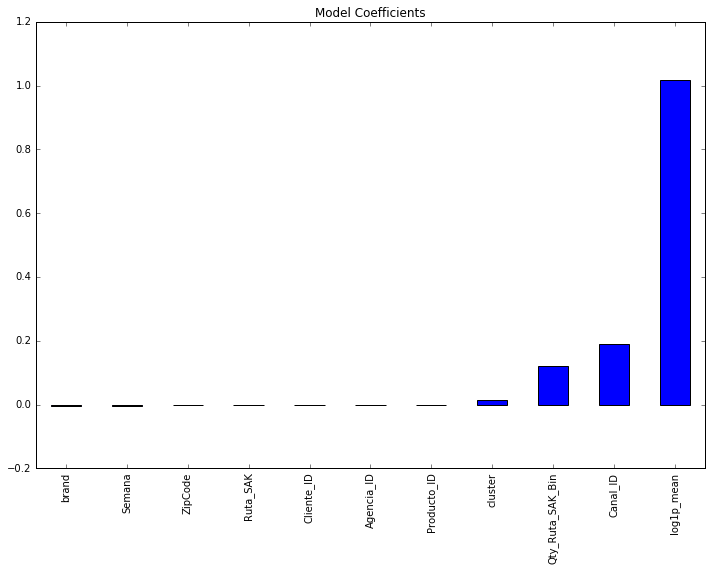

In [7]:
predictors = [x for x in train.columns if x not in [target]+[IDcol]]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, val, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

Though the regression coefficient look better now, the score is about the same (or worst). We can tune the parameters of the model for slightly better results but I don’t think there will be a significant improvement.

### Decision Tree Model

Lets try out a decision tree model and see if we get something better.


Model Report
RMSLE TRAIN:  0.332406177773
RMSLE VAL:  0.332199206592
RMSE TRAIN 8.37044619309
RMSE VAL 8.74236258257
Time passed: 0hour:14min:33sec


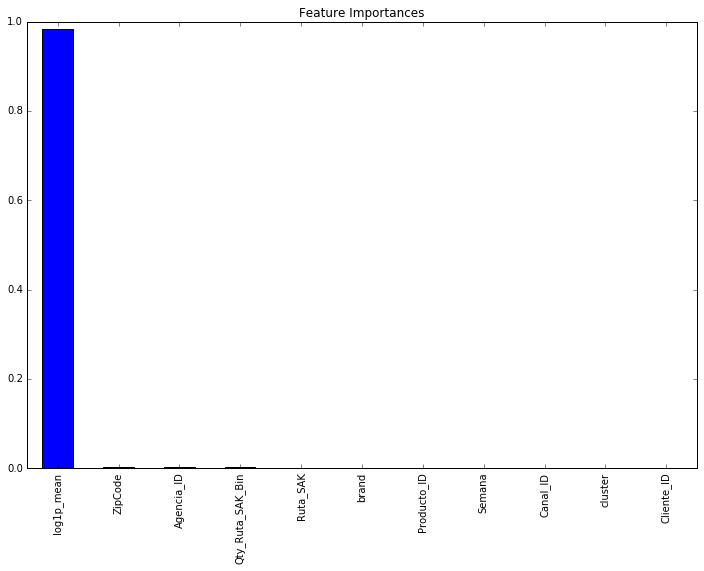

In [9]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+[IDcol]]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
tic()
modelfit(alg3, train, val, test, predictors, target, IDcol, 'alg3.csv')
tac()
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

Lets try making a decision tree with just top 4 variables, a max_depth of 25 and min_samples_leaf as 150.


Model Report
RMSLE TRAIN:  0.334600876812
RMSLE VAL:  0.338251807897
RMSE TRAIN 8.67127973648
RMSE VAL 8.98556055503
Time passed: 0hour:6min:45sec


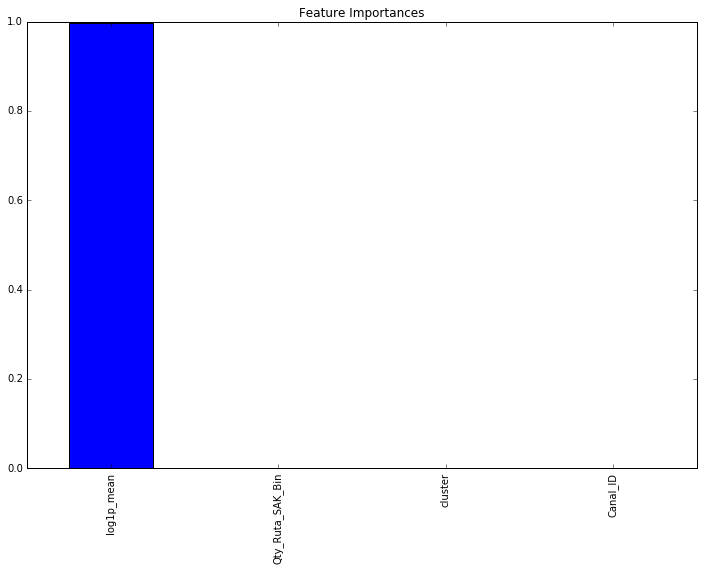

In [ ]:
predictors = ['log1p_mean','Canal_ID','Qty_Ruta_SAK_Bin','cluster']
alg4 = DecisionTreeRegressor(max_depth=25, min_samples_leaf=150)
tic()
modelfit(alg4, train, val, test, predictors, target, IDcol, 'alg4.csv')
tac()
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

We can fine tune the model further using other parameters. But let's try now a Random Forest to see if we get some improvement

### Random Forest Model


Model Report
RMSLE TRAIN:  0.329898813005
RMSLE VAL:  0.33276301887
RMSE TRAIN 8.46446927931
RMSE VAL 8.78674239628
Time passed: 1hour:51min:22sec


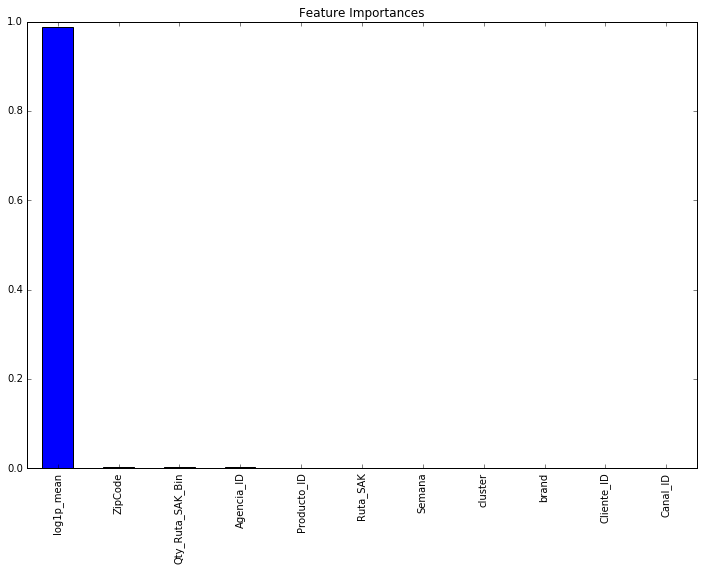

In [6]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+[IDcol]]
alg5 = RandomForestRegressor(n_estimators=10,max_depth=25, min_samples_leaf=150,n_jobs=-1)
tic()
modelfit(alg5, train, val, test, predictors, target, IDcol, 'alg5.csv')
tac()
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')

As we can see.. not much better.